<a href="https://colab.research.google.com/github/Josh413/Forecasting-Models-UConn-Research-2025-/blob/main/ML_Project%5BLOAD%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0]	test-rmse:2375.28848
[10]	test-rmse:1506.48052
[20]	test-rmse:1007.40220
[30]	test-rmse:699.88082
[40]	test-rmse:527.28835
[50]	test-rmse:425.97819
[60]	test-rmse:380.61423
[70]	test-rmse:348.27511
[80]	test-rmse:333.68849
[90]	test-rmse:319.24406
[100]	test-rmse:310.19002
[110]	test-rmse:302.37030
[120]	test-rmse:296.16979
[130]	test-rmse:291.20641
[140]	test-rmse:284.30826
[150]	test-rmse:280.44151
[160]	test-rmse:277.76535
[170]	test-rmse:272.78650
[180]	test-rmse:269.70576
[190]	test-rmse:265.59944
[200]	test-rmse:264.32208
[210]	test-rmse:260.69757
[220]	test-rmse:259.18672
[230]	test-rmse:259.79560
[240]	test-rmse:260.39721
[250]	test-rmse:258.95265
[260]	test-rmse:258.14932
[270]	test-rmse:259.44679
[280]	test-rmse:258.71714
[290]	test-rmse:256.53244
[300]	test-rmse:255.35538
[310]	test-rmse:254.98162
[320]	test-rmse:254.86191
[330]	test-rmse:253.55496
[340]	test-rmse:253.22847
[350]	test-rmse:253.81544
[360]	test-rmse:255.15509
[370]	test-rmse:255.37923
[380]	test-rmse:254.

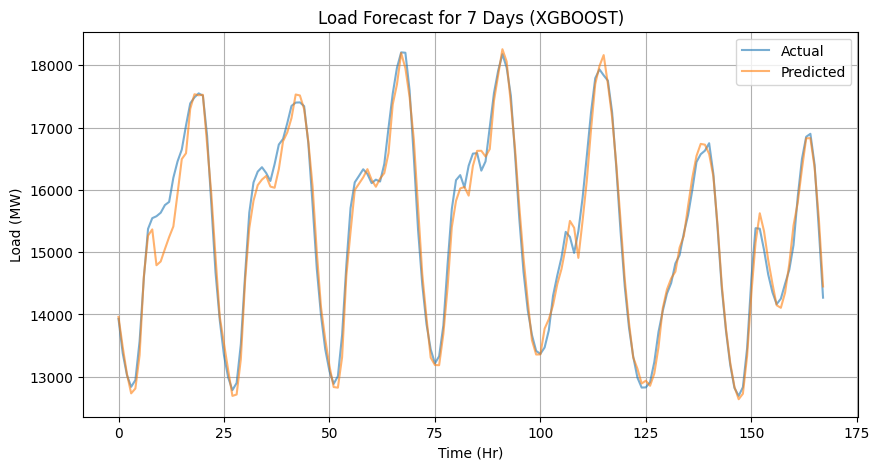

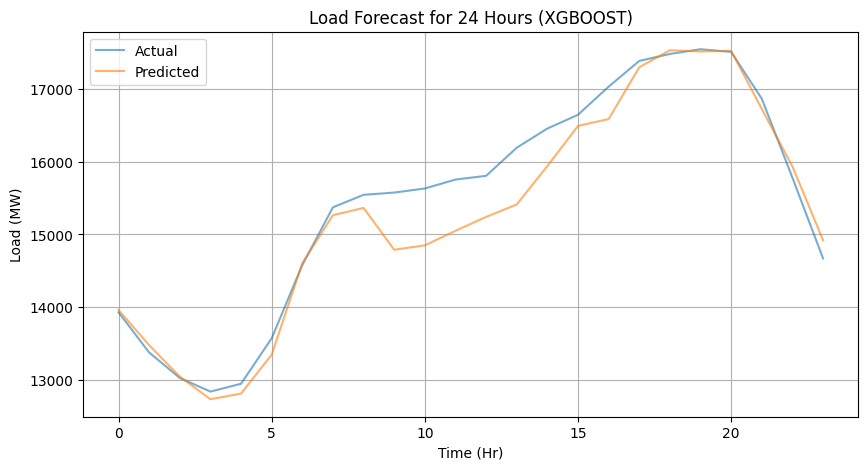

*Actual load data from 2025-05-13 00:00:00
RMSE: 251.59 MW
MPE: 0.21%


In [ ]:
#XGBOOST MODEL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Flatten, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

df = pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(
    id_vars=['Year', 'Month', 'Day'],
    value_vars=[f'Hr{i}' for i in range (1, 25)],
    var_name='HourTitle',
    value_name='Load'
)
df_melted = df_melted.dropna(subset=['Load'])
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int) - 1
df_melted['Time Stamp'] = (
    pd.to_datetime(df_melted[['Year', 'Month', 'Day']]) +
    pd.to_timedelta(df_melted['Hour'], unit='h')
)
df_final = df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp')
df_final = df_final.set_index('Time Stamp').sort_index()

lags=[1,2,3,6,12,18,24,48,72]
for lag in lags:
    df_final[f'Load_lag_{lag}']=df_final['Load'].shift(lag)
df_final['hour_sin']=np.sin(2*np.pi*df_final.index.hour/24)
df_final['hour_cos']=np.cos(2*np.pi*df_final.index.hour/24)
df_final['doy_sin']=np.sin(2*np.pi*df_final.index.dayofyear/365)
df_final['doy_cos']=np.cos(2*np.pi*df_final.index.dayofyear/365)
df_final=df_final.dropna()

n_test=24*30
df_final_train=df_final.iloc[:-n_test]
df_final_test=df_final.iloc[-n_test:]

x_train=df_final_train.drop(columns='Load')
y_train=df_final_train['Load']
x_test=df_final_test.drop(columns='Load')
y_test=df_final_test['Load']

dtrain=xgb.DMatrix(x_train,label=y_train)
dtest=xgb.DMatrix(x_test,label=y_test)

params={'objective':'reg:squarederror', 'learning_rate': 0.05, 'max_depth': 4,
        'subsample': 0.8, 'colsample_bytree': 0.8}
model=xgb.train(params, dtrain, num_boost_round=5000, early_stopping_rounds=200,
                evals=[(dtest, 'test')], verbose_eval=10)

y_pred=model.predict(dtest)

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:24*7], label='Actual', alpha=0.6)
plt.plot(y_pred[:24*7], label='Predicted', alpha=0.6)
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.title('Load Forecast for 7 Days (XGBOOST)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:24], label='Actual', alpha=0.6)
plt.plot(y_pred[:24], label='Predicted', alpha=0.6)
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.title('Load Forecast for 24 Hours (XGBOOST)')
plt.legend()
plt.grid()
plt.show()

test_start_index = len(df_final) - len(y_test)
print('*Actual load data from',df_final.index[test_start_index])
rmse=(np.sqrt(mean_squared_error(y_test.values, y_pred)))
mpe=(np.mean((y_test.values-y_pred)/y_test.values)*100)
print(f'RMSE: {rmse:.2f} MW')
print(f'MPE: {mpe:.2f}%')





Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - loss: 0.1218 - val_loss: 0.0155
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - loss: 0.0207 - val_loss: 0.0138
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - loss: 0.0174 - val_loss: 0.0110
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - loss: 0.0141 - val_loss: 0.0099
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step - loss: 0.0126 - val_loss: 0.0091
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - loss: 0.0114 - val_loss: 0.0079
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/ste

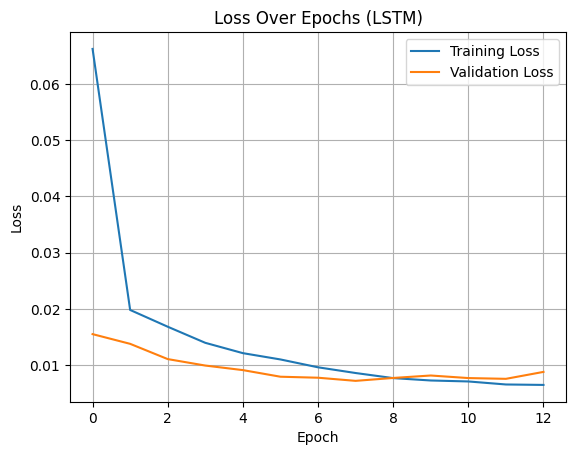

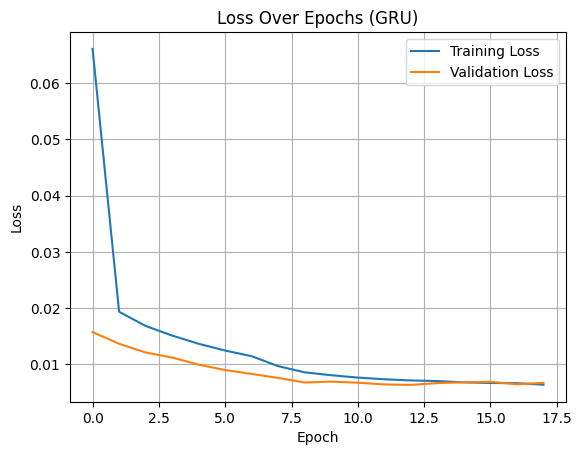

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


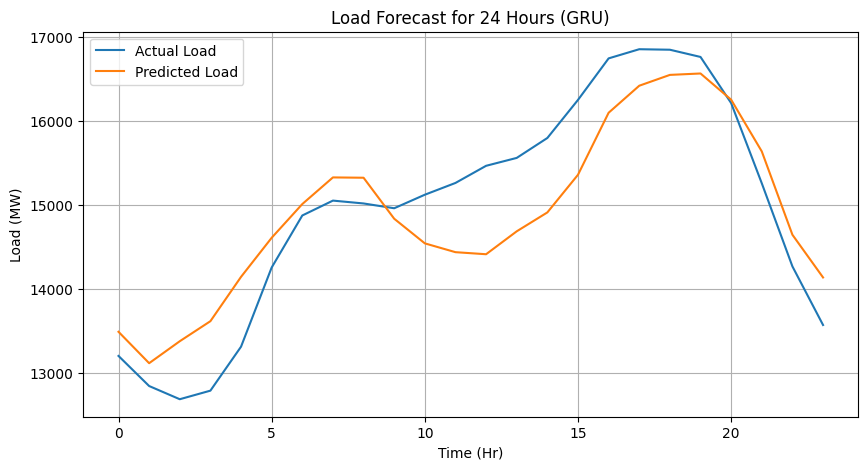

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


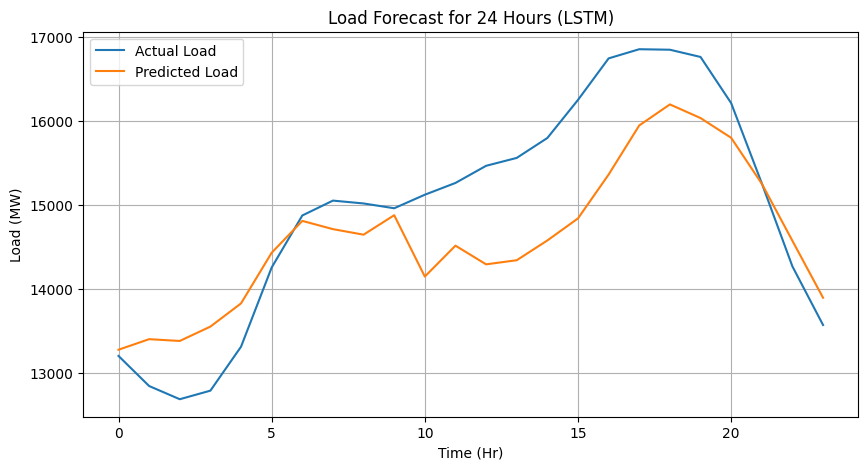

*Actual load data from 2025-05-29 00:00:00
Data starts from: 2025-01-01 00:00:00
Data ends at: 2025-06-11 23:00:00
RMSE (LSTM): 1517.21 MW
MPE (LSTM): 1.49%
RMSE (GRU): 1358.64 MW
MPE (GRU): -0.20%


In [ ]:
#LSTM/GRU MODELS
import pandas as pd
import numpy as np
import holidays
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

us_holidays = holidays.US(state='NY')
df=pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(
    id_vars=['Year', 'Month', 'Day'],
    value_vars=[f'Hr{i}' for i in range(1, 25)],
    var_name='HourTitle',
    value_name='Load'
)
df_melted = df_melted.dropna(subset=['Load'])
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int)-1
df_melted['Time Stamp'] = (pd.to_datetime(df_melted[['Year', 'Month', 'Day']])
+ pd.to_timedelta(df_melted['Hour'], unit='h'))
df_final =(df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp'))
df_final = df_final.set_index('Time Stamp').sort_index()
df_final['hour'] = df_final.index.hour
df_final['dayofweek'] = df_final.index.dayofweek
df_final['is_weekend'] = df_final['dayofweek'].isin([5, 6]).astype(int)
df_final['is_holiday'] = np.isin(df_final.index.date, us_holidays).astype(int)

feature_cols = ['Load', 'hour', 'dayofweek', 'is_weekend','is_holiday']
scalers = {}

for col in feature_cols:
    scaler = MinMaxScaler()
    df_final[col + '_scaled'] = scaler.fit_transform(df_final[[col]])
    scalers[col] = scaler
input_features = ['Load_scaled', 'hour_scaled', 'dayofweek_scaled',
                  'is_weekend_scaled', 'is_holiday_scaled']
scaler = MinMaxScaler()
df_final['Load Scaled'] = scaler.fit_transform(df_final['Load'].values.reshape(-1,1))
data = df_final[input_features].values

window=24*7
forecast=24

def sequence(data, window, forecast, target_index=0):
    x, y = [], []
    for i in range(len(data) - window - forecast + 1):
        x.append(data[i:i+window])
        y.append(data[i+window:i+window+forecast,target_index])
    return np.array(x), np.array(y)
x, y = sequence(data, window, forecast,target_index=0)

n_test = 14 * 24
x_train, x_test = x[:-n_test], x[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

model_LSTM = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window, x_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(forecast)
])
model_LSTM.compile(optimizer='adam', loss='mse')
history_LSTM = model_LSTM.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

model_GRU = Sequential([
    GRU(64, return_sequences=True, input_shape=(window, x_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(forecast)
])
model_GRU.compile(optimizer='adam', loss='mse')
history_GRU = model_GRU.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)



plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (LSTM)')
plt.legend()
plt.grid()
plt.show()

plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (GRU)')
plt.legend()
plt.grid()
plt.show()


y_predGRU = model_GRU.predict(x_test)
y_pred_originalGRU = scaler.inverse_transform(y_predGRU.reshape(-1, 1)).reshape(y_predGRU.shape)
y_test_originalGRU = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
plt.figure(figsize=(10,5))
plt.plot(np.arange(24), y_test_originalGRU[0], label='Actual Load')
plt.plot(np.arange(24), y_pred_originalGRU[0], label='Predicted Load')

plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.title('Load Forecast for 24 Hours (GRU)')
plt.legend()
plt.grid()
plt.show()

y_pred = model_LSTM.predict(x_test)
y_pred_originalLSTM = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_originalLSTM = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
plt.figure(figsize=(10,5))
plt.plot(np.arange(24), y_test_originalLSTM[0], label='Actual Load')
plt.plot(np.arange(24), y_pred_originalLSTM[0], label='Predicted Load')

plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.title('Load Forecast for 24 Hours (LSTM)')
plt.legend()
plt.grid()
plt.show()

rmse_LSTM = (np.sqrt(mean_squared_error(y_test_originalLSTM.flatten(),
                                   y_pred_originalLSTM.flatten())))
mpe_LSTM = (np.mean((y_test_originalLSTM.flatten() - y_pred_originalLSTM.flatten())
/ y_test_originalLSTM.flatten()) * 100)

rmse_GRU = (np.sqrt(mean_squared_error(y_test_originalGRU.flatten(),
                                   y_pred_originalGRU.flatten())))
mpe_GRU = (np.mean((y_test_originalGRU.flatten() - y_pred_originalGRU.flatten())
/ y_test_originalGRU.flatten()) * 100)


test_start_index = len(df_final) - len(y_test)
print('*Actual load data from',df_final.index[test_start_index])
print("Data starts from:", df_final.index.min())
print("Data ends at:", df_final.index.max())
print(f'RMSE (LSTM): {rmse_LSTM:.2f} MW')
print(f'MPE (LSTM): {mpe_LSTM:.2f}%')
print(f'RMSE (GRU): {rmse_GRU:.2f} MW')
print(f'MPE (GRU): {mpe_GRU:.2f}%')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0423 - val_loss: 0.0062
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss:

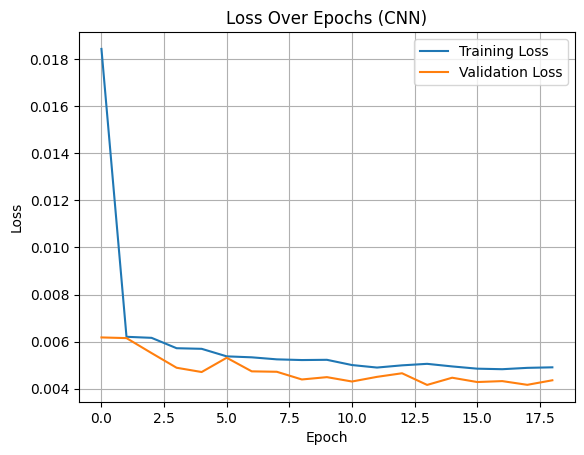

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


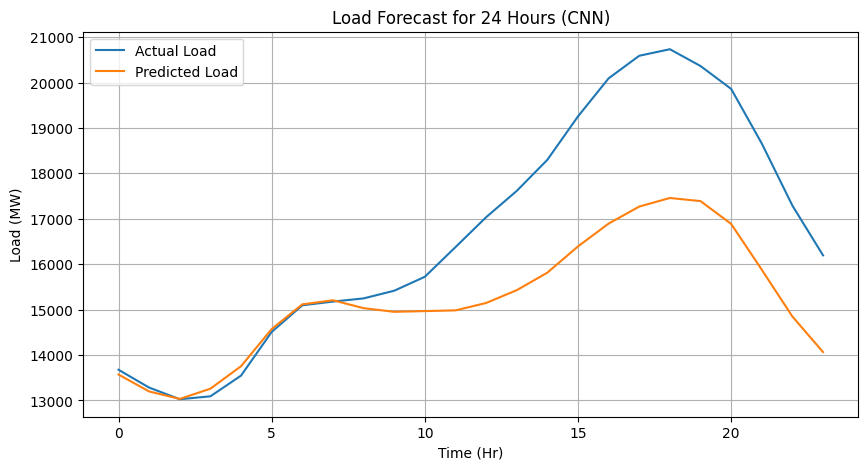

*Actual load data from 2025-06-05 00:00:00
Data starts from: 2025-01-01 00:00:00
Data ends at: 2025-06-11 23:00:00
RMSE (CNN): 1394.24 MW
MPE (CNN): 3.61%


In [ ]:
#CNN MODEL
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

df=pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(
    id_vars=['Year', 'Month', 'Day'],
    value_vars=[f'Hr{i}' for i in range(1, 25)],
    var_name='HourTitle',
    value_name='Load'
)
df_melted = df_melted.dropna(subset=['Load'])
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int)-1
df_melted['Time Stamp'] = (pd.to_datetime(df_melted[['Year', 'Month', 'Day']])
+ pd.to_timedelta(df_melted['Hour'], unit='h'))
df_final =(df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp'))
df_final = df_final.set_index('Time Stamp').sort_index()

scaler = MinMaxScaler()
df_final['Load Scaled'] = ( scaler.fit_transform(df_final['Load'].values.
                                                 reshape(-1,1)))
data=df_final['Load Scaled'].values
window=24*7
forecast=24

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

def sequence(data, window, forecast):
    x, y = [], []
    for i in range(len(data) - window - forecast + 1):
        x.append(data[i:i+window])
        y.append(data[i+window:i+window+forecast])
    return np.array(x), np.array(y)
x, y = sequence(data, window, forecast)

from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test =( train_test_split(x, y, test_size=0.2,
                                                     #shuffle=False))

n_test = 7 * 24
x_train, x_test = x[:-n_test], x[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=(window,
                                                                      1)),
    Flatten(),
    Dense(24)])
model_cnn.compile(optimizer='adam', loss='mse')
history_cnn = model_cnn.fit(x_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop])


plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (CNN)')
plt.legend()
plt.grid()
plt.show()

y_predcnn = model_cnn.predict(x_test)
y_pred_originalcnn = scaler.inverse_transform(y_predcnn)
y_test_originalcnn = scaler.inverse_transform(y_test)
plt.figure(figsize=(10,5))
plt.plot(np.arange(24), y_test_originalcnn[0], label='Actual Load')
plt.plot(np.arange(24), y_pred_originalcnn[0], label='Predicted Load')

plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.title('Load Forecast for 24 Hours (CNN)')
plt.legend()
plt.grid()
plt.show()

rmse_cnn = (np.sqrt(mean_squared_error(y_test_originalcnn.flatten(),
                                   y_pred_originalcnn.flatten())))
mpe_cnn = (np.mean((y_test_originalcnn.flatten() - y_pred_originalcnn.flatten())
/ y_test_originalcnn.flatten()) * 100)

test_start_index = len(df_final) - len(y_test)
print('*Actual load data from',df_final.index[test_start_index])
print("Data starts from:", df_final.index.min())
print("Data ends at:", df_final.index.max())
print(f'RMSE (CNN): {rmse_cnn:.2f} MW')
print(f'MPE (CNN): {mpe_cnn:.2f}%')





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 17)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 72, 17)    │      9,105 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 72, 17)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 17)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 72, 17)    │         34 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 72, 64)    │      1,152 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 72, 17)    │      1,105 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 72, 17)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 72, 17)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 72, 17)    │         34 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 72, 17)    │      9,105 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 72, 17)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 72, 17)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 72, 17)    │         34 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 72, 64)    │      1,152 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 72, 17)    │      1,105 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 72, 17)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 72, 17)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 72, 17)    │         34 │ add_4[0][0]     

 Total params: 73,456 (286.94 KB)

 Trainable params: 73,456 (286.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000
85/85 - 24s - 287ms/step - loss: 292614112.0000 - val_loss: 214104064.0000
Epoch 2/5000
85/85 - 18s - 212ms/step - loss: 274992416.0000 - val_loss: 186162480.0000
Epoch 3/5000
85/85 - 7s - 88ms/step - loss: 224851760.0000 - val_loss: 128299880.0000
Epoch 4/5000
85/85 - 10s - 121ms/step - loss: 144382064.0000 - val_loss: 57919276.0000
Epoch 5/5000
85/85 - 9s - 102ms/step - loss: 64221536.0000 - val_loss: 11952784.0000
Epoch 6/5000
85/85 - 10s - 120ms/step - loss: 19260594.0000 - val_loss: 2708841.0000
Epoch 7/5000
85/85 - 9s - 111ms/step - loss: 7426449.5000 - val_loss: 5701582.0000
Epoch 8/5000
85/85 - 9s - 102ms/step - loss: 6075351.0000 - val_loss: 7101845.0000
Epoch 9/5000
85/85 - 9s - 102ms/step - loss: 5987258.0000 - val_loss: 7242064.0000
Epoch 10/5000
85/85 - 9s - 111ms/step - loss: 5939720.5000 - val_loss: 7523859.5000
Epoch 11/5000
85/85 - 10s - 115ms/step - loss: 5977279.0000 - val_loss: 8194643.0000
Epoch 12/5000
85/85 - 9s - 106ms/step - loss: 5988302.5000 - va

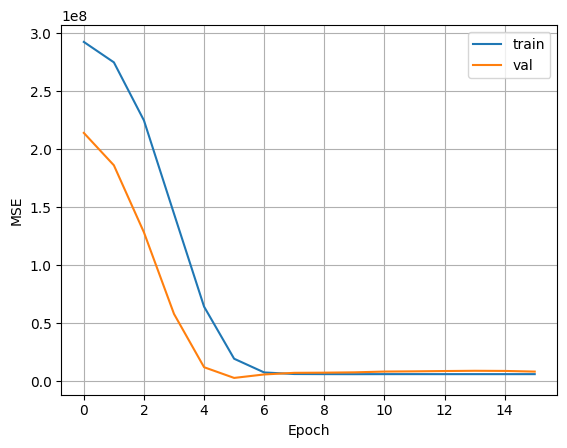

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


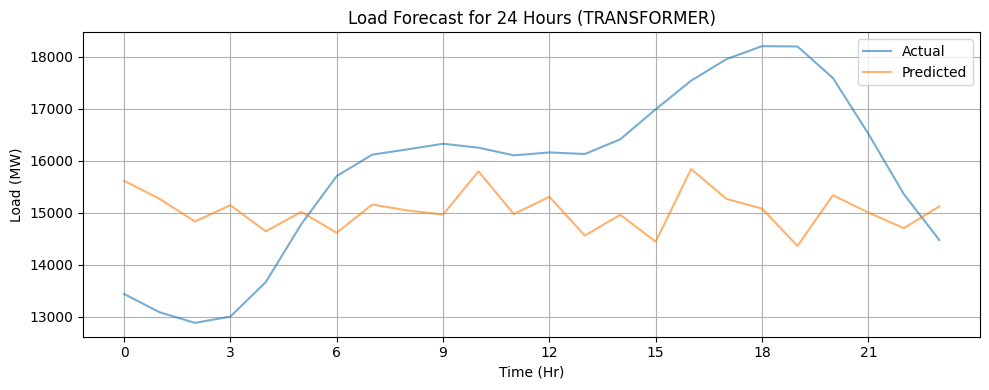

*Actual load data from 2025-05-16 23:00:00
RMSE: 2149.027
MAPE: 10.78%


In [1]:
# TRANSFORMER MODEL
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, Add, Embedding, Flatten, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

df = pd.read_csv('nyiso_loads (1).csv')
df_melted = df.melt(id_vars=['Year', 'Month', 'Day'],
                    value_vars=[f'Hr{i}' for i in range(1, 25)],
                    var_name='HourTitle', value_name='Load')
df_melted = df_melted.dropna(subset=['Load'])
df_melted['Hour'] = df_melted['HourTitle'].str.extract('Hr(\d+)').astype(int) - 1
df_melted['Time Stamp'] = (pd.to_datetime(df_melted[['Year', 'Month', 'Day']])
                           + pd.to_timedelta(df_melted['Hour'], unit='h'))
df_final = df_melted[['Time Stamp', 'Load']].sort_values('Time Stamp').set_index('Time Stamp')

df_final['hour'] = df_final.index.hour
df_final['dayofweek'] = df_final.index.dayofweek
df_final['month'] = df_final.index.month

scaler = MinMaxScaler()
df_final['Load_Scaled'] = scaler.fit_transform(df_final['Load'].values.reshape(-1, 1))

lags = [1, 2, 3, 6, 12, 18, 24, 48, 72]
for lag in lags:
    df_final[f'Load_lag_{lag}'] = df_final['Load'].shift(lag)

df_final['hour_sin'] = np.sin(2 * np.pi * df_final.index.hour / 24)
df_final['hour_cos'] = np.cos(2 * np.pi * df_final.index.hour / 24)
df_final['doy_sin'] = np.sin(2 * np.pi * df_final.index.dayofyear / 365)
df_final['doy_cos'] = np.cos(2 * np.pi * df_final.index.dayofyear / 365)
df_final = df_final.dropna()

n_test = 30 * 24
train_df_final = df_final.iloc[:-n_test]
test_df_final = df_final.iloc[-n_test:]

FEATURE_COLS = [c for c in df_final.columns if c != 'Load']
WINDOW = 72
FORECAST = 24

def make_xy(df_final, feature_cols, window, forecast):
    X, Y = [], []
    arr = df_final[feature_cols].values
    w = window + forecast
    for i in range(len(arr) - w + 1):
        X.append(arr[i:i+window])
        Y.append(df_final['Load'].values[i+window-forecast+1:i+window+1])
    return np.array(X), np.array(Y)

X_train, y_train = make_xy(train_df_final, FEATURE_COLS, WINDOW, FORECAST)
X_test, y_test = make_xy(test_df_final, FEATURE_COLS, WINDOW, FORECAST)

def transformer_block(x, head_size, num_heads, ff_dim, dropout):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn = Dropout(dropout)(attn)
    out1 = Add()([x, attn])
    out1 = LayerNormalization()(out1)

    ff = Dense(ff_dim, activation='relu')(out1)
    ff = Dense(x.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    out2 = Add()([out1, ff])
    return LayerNormalization()(out2)

inp = Input(shape=(WINDOW, len(FEATURE_COLS)))
x = inp

pos = np.arange(WINDOW)
pos_emb = Embedding(input_dim=WINDOW, output_dim=len(FEATURE_COLS))(pos)
pos_emb = tf.expand_dims(pos_emb, axis=0)
x = x + pos_emb

for _ in range(2):
    x = transformer_block(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)

dec_in = Lambda(lambda t: K.repeat_elements(t[:, -1:, :], rep=FORECAST, axis=1))(x)

pos_dec = np.arange(FORECAST)
dec_pos = Embedding(input_dim=FORECAST, output_dim=len(FEATURE_COLS))(pos_dec)
dec_pos = tf.expand_dims(dec_pos, axis=0)
dec = dec_in + dec_pos

for _ in range(2):
    dec = transformer_block(dec, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)

dec = Flatten()(dec)
dec = Dense(64, activation='relu')(dec)
out = Dense(FORECAST)(dec)

model = Model(inputs=inp, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5000,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(range(FORECAST), y_test[0], label='Actual', alpha=0.6)
plt.plot(range(FORECAST), y_pred[0], label='Predicted', alpha=0.6)
plt.title('Load Forecast for 24 Hours (TRANSFORMER)')
plt.xlabel('Time (Hr)')
plt.ylabel('Load (MW)')
plt.xticks(range(0, FORECAST, 3))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_start_index = len(df_final) - len(y_test)
print(f'*Actual load data from {df_final.index[test_start_index]}')
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mape = mean_absolute_percentage_error(y_test.flatten(), y_pred.flatten()) * 100
print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.2f}%')